######  <span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#35c359">LDA Project
<font color=darkblue>
    
######  <span style="font-family: Arial; font-weight:bold;font-size:1.em;color:#d40eea">Import Libraries
<font color=darkblue>

In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

######  <span style="font-family: Arial; font-weight:bold;font-size:1.em;color:#120eea">Load and display Dataset

In [2]:
dataset = pd.read_csv('/Users/preethamvignesh/Desktop/Work/ML_EIT/Data/sport_garden.csv')
dataset.head()

,Description,label
0,This is how I pictured Rachel Lind's house in ...,gardening
1,Came here to say exactly this!,gardening
2,Rachel Lind's house? Really??,gardening
3,"Of course, she would have nothing but the best...",gardening
4,"Let's be kindred spirits, please.",gardening


######  <span style="font-family: Arial; font-weight:bold;font-size:1.em;color:#120eea">Initial Data cleaning

In [3]:
# drop columns that aren't going to be used
cleaned_dataset = dataset.drop(['label'], axis=1)
# remove useless text parts
cleaned_dataset['Description'] = cleaned_dataset['Description'].replace(to_replace='xx/xx/\d{4}|XX/XX/\d{4}|\d\d/\d\d/\d{4}|xx/xx/\d{2}|XX/XX/\d{2}|\d\d/\d\d/\d{2}|xx+|XX+|{|}|\$\d+(\.\d+)?', value='', regex=True)
# replace consecutive spaces by only one space
cleaned_dataset['Description'] = cleaned_dataset['Description'].replace(to_replace='\s\s+', value=' ', regex=True)

In [4]:
cols = ['Description']
ids = []
label_to_id = []
id_to_label = []

count = 0
for c in cols:
    one_hot_encoding = pd.get_dummies(cleaned_dataset[c], prefix = c)
    cleaned_dataset = pd.concat([cleaned_dataset, one_hot_encoding], axis = 1)
    
    cleaned_dataset[c + ' id'] = cleaned_dataset[c].factorize()[0]
    ids.append(cleaned_dataset[[c, c + ' id']].drop_duplicates().sort_values(c + ' id'))
    label_to_id.append(dict(ids[count].values))
    id_to_label.append(dict(ids[count][[c + ' id', c]].values))
    count += 1

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/preethamvignesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/preethamvignesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/preethamvignesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

######  <span style="font-family: Arial; font-weight:bold;font-size:1.em;color:#7c0eea">Data cleaning by removing symbols, short words, stopwords and by stemming words to their dictionary form by using a lemmatizer.

In [6]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()

def clean_col(col):
    cleaned_col = []
    for r in range(0,len(col)):
        row = str(col[r])
        row = row.lower()
        row = re.sub('[^a-zA-Z]',' ', row)
        row = re.sub(r'\b\w{1}\b', '', row)

        word_tokens = word_tokenize(row)
        
        row = [w for w in word_tokens if w not in stop_words]
        row = ' '.join(row)
        row = [lemma.lemmatize(w) for w in word_tokenize(str(row).lower())]
        row = ' '.join(row)
        cleaned_col.append(row)
    return cleaned_col

In [7]:
%%time

cleaned_dataset['Description'] = clean_col(cleaned_dataset['Description'])

CPU times: user 4.43 s, sys: 77.8 ms, total: 4.51 s
Wall time: 4.53 s


In [8]:
show_n_rows = 5

pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = show_n_rows

cleaned_dataset['Description'].head(show_n_rows)

0                                pictured rachel lind house anne green gable
1                                                           came say exactly
2                                                   rachel lind house really
3    course would nothing best kept garden imagined style similar anne house
4                                                  let kindred spirit please
Name: Description, dtype: object

######  <span style="font-family: Arial; font-weight:bold;font-size:1.em;color:#be0eea">Train a Doc2Vec model.

In [9]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

X = cleaned_dataset['Description']
Y = [[i] for i in range(len(X))]
tagged_data  = [TaggedDocument(X[i], Y[i]) for i in range(len(X))]


model = Doc2Vec(
    vector_size=50, 
    alpha=0.025, 
    min_alpha=0.00025, 
    min_count=2, 
    sample=0.00001, 
#     window=25, 
#     negative=5, 
    dm=1
)

model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)


filename = "doc2vec_model"
model.save(filename)
print("Model Saved (" + filename + ")")

Model Saved (doc2vec_model)


######  <span style="font-family: Arial; font-weight:bold;font-size:1.em;color:#ea0eac">Vectorize the whole dataset with the trained model

In [10]:
from gensim.models.doc2vec import Doc2Vec

fname = "doc2vec_model"
model = Doc2Vec.load(fname)
X = cleaned_dataset['Description']

vectorized_complaints = []
for x in X[:]:
    vectorized_complaints.append(model.infer_vector(list(x)))

######  <span style="font-family: Arial; font-weight:bold;font-size:1.em;color:#ea0e62">Perform PCA on the vectorized dataset for outlier detection

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(vectorized_complaints)
pca_vectorized_complaints = pca.transform(vectorized_complaints)

######  <span style="font-family: Arial; font-weight:bold;font-size:1.em;color:#0eeac9">Perform SVD on the vectorized dataset for outlier detection

In [12]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
svd_vectorized_complaints = svd.fit_transform(vectorized_complaints)

######  <span style="font-family: Arial; font-weight:bold;font-size:1.em;color:#0eea9d">Function to detect outliers with 4 different algorithms.

In [13]:
import time

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

def compute_and_plot_outliers(data, outliers_fraction=0.01):
    anomaly_algorithms = [
        ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
        ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
        ("Isolation Forest", IsolationForest(contamination=outliers_fraction)),
        ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction))
    ]

    xx, yy = np.meshgrid(np.linspace(-1, 1, 150), np.linspace(-1, 1, 150))

    y_preds = []
    
    for name, algorithm in anomaly_algorithms:
        t0 = time.time()

        algorithm.fit(data)

        plt.figure(figsize=(10, 10))
        plt.title("Outlier detection with " + name, size=18)

        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(data)
        else:
            y_pred = algorithm.fit(data).predict(data)
        
        y_preds.append(y_pred)

        if name != "Local Outlier Factor":
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

        t1 = time.time()

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(data[:, 0], data[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'), transform=plt.gca().transAxes, size=15, horizontalalignment='right')
        
        plt.show()
    
    return y_preds

######  <span style="font-family: Arial; font-weight:bold;font-size:1.em;color:#0eea57">Detect outliers both by using PCA and SVD

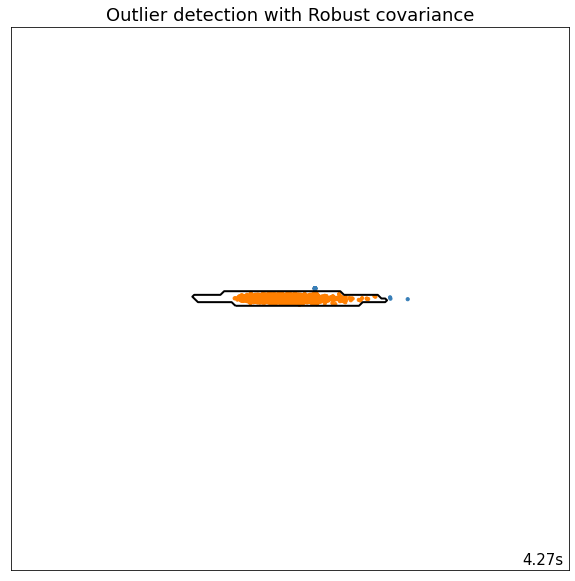

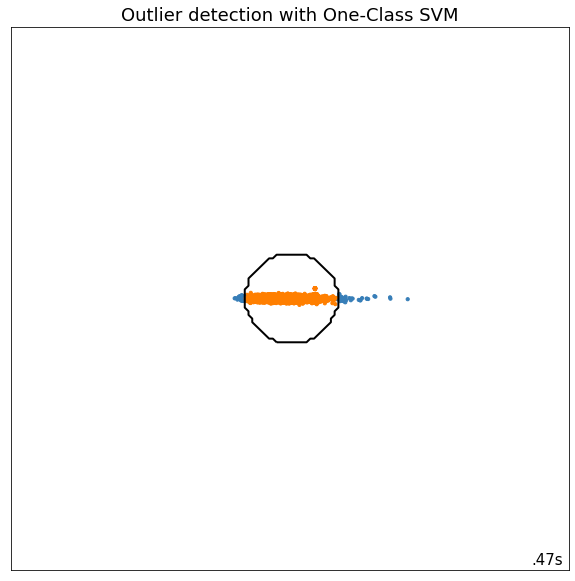

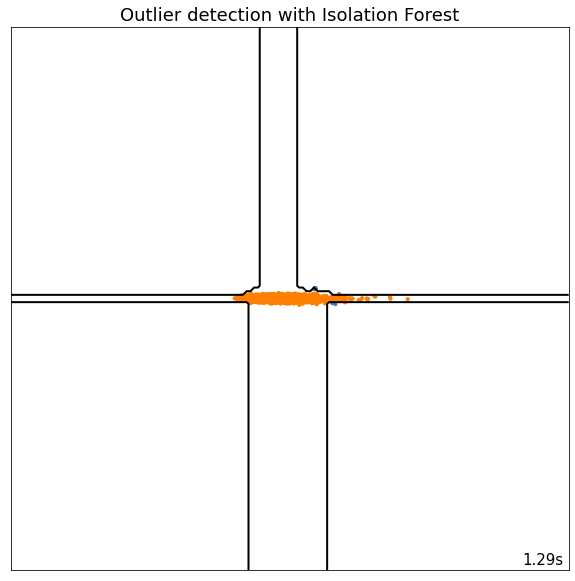

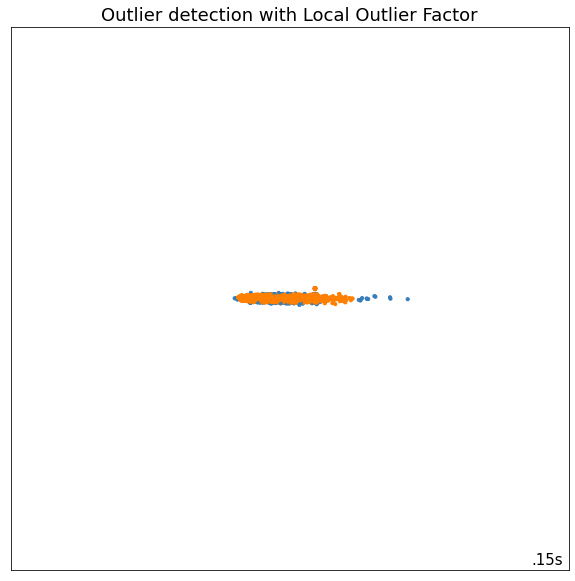

In [14]:
pca_y_preds = compute_and_plot_outliers(pca_vectorized_complaints)

######  <span style="font-family: Arial; font-weight:bold;font-size:1.em;color:#0eea57">Get all complaint ids that are labelled as outliers.

In [15]:
def get_outlier_ids(y_pred):
    outlier_ids = []

    for id in range(0, len(y_pred)):
        if y_pred[id] == -1:
            outlier_ids.append(id)
    
    return outlier_ids

######  <span style="font-family: Arial; font-weight:bold;font-size:1.em;color:#0eea57">Get all outliers per algorithm (PCA)

In [16]:
pca_outlier_ids = []
for o in range(0, len(pca_y_preds)):
    outliers = get_outlier_ids(pca_y_preds[o])
    pca_outlier_ids.append(outliers)
    
    print('#outliers:', len(outliers))

#outliers: 84
#outliers: 84
#outliers: 84
#outliers: 84


In [17]:
print('# of complaints in cleaned_dataset:', cleaned_dataset.shape[0])

# of complaints in cleaned_dataset: 8360


In [18]:
dataset_excluding_outliers = dataset.drop(dataset.index[pca_outlier_ids[0]])
print('# of complaints in cleaned_dataset_excluding_outliers:', dataset_excluding_outliers.shape[0])

# of complaints in cleaned_dataset_excluding_outliers: 8276


######  <span style="font-family: Arial; font-weight:bold;font-size:1.em;color:#dbea0e">Use pickle to save the dataset without outliers to a file

In [19]:
filename = 'dataset_excluding_outliers.csv'
dataset_excluding_outliers.to_csv(filename, index=False)

In [20]:
import pandas as pd

filename = 'dataset_excluding_outliers.csv'
dataset_excluding_outliers = pd.read_csv(filename) 

In [21]:
print('# of complaints in vectorized_complaints:', len(vectorized_complaints))

# of complaints in vectorized_complaints: 8360


In [22]:
vectorized_complaints_cleaned = []

for index in range(0, len(vectorized_complaints)):
    if index not in pca_outlier_ids[0]:
        vectorized_complaints_cleaned.append(vectorized_complaints[index])

print('# of complaints in vectorized_complaints_cleaned:', len(vectorized_complaints_cleaned))

# of complaints in vectorized_complaints_cleaned: 8276


**Use pickle to save the cleaned vectorized complaints to a file.**

In [23]:
import pickle

filename = 'vectorized_complaints_cleaned.pkl'
data = vectorized_complaints_cleaned
output = open(filename, 'wb')
pickle.dump(data, output)
output.close()

In [24]:
import pickle

filename = 'vectorized_complaints_cleaned.pkl'
pkl_file = open(filename, 'rb')
data = pickle.load(pkl_file)
pkl_file.close()

######  <span style="font-family: Arial; font-weight:bold;font-size:1.em;color:#eab70e">Clustering

In [25]:
import pandas as pd

filename = 'dataset_excluding_outliers.csv'
cleaned_dataset_excluding_outliers = pd.read_csv(filename) 

In [26]:
import re

# drop columns that aren't going to be used
cleaned_dataset_excluding_outliers = cleaned_dataset_excluding_outliers.drop(['label'], axis=1)
# remove useless text parts
cleaned_dataset_excluding_outliers['Description'] = cleaned_dataset_excluding_outliers['Description'].replace(to_replace='xx/xx/\d{4}|XX/XX/\d{4}|\d\d/\d\d/\d{4}|xx/xx/\d{2}|XX/XX/\d{2}|\d\d/\d\d/\d{2}|xx+|XX+|{|}|\$\d+(\.\d+)?', value='', regex=True)
# replace consecutive spaces by only one space
cleaned_dataset_excluding_outliers['Description'] = cleaned_dataset_excluding_outliers['Description'].replace(to_replace='\s\s+', value=' ', regex=True)

In [27]:
%%time

cleaned_dataset_excluding_outliers['Description'] = clean_col(cleaned_dataset_excluding_outliers['Description'])

CPU times: user 2.95 s, sys: 9.5 ms, total: 2.96 s
Wall time: 2.97 s


In [28]:
doc_sample = cleaned_dataset_excluding_outliers['Description']
processed_docs = doc_sample.tolist()

extra_stopwords = [
    'told', 'still', 'one', 'said', 'asked', 'sent', 'call', 'amount', 'received', 'would', 
    'could', 'day', 'since', 'never', 'also', 'time', 'back', 'year', 'get', 'even', 
    'paid', 'month', 'pay', 'money', 'bank', 'however', 'made', 'due', 'email', 'stated', 
    'name', 'date', 'want', 'need', 'first', 'know'
]

processed_docs = map(lambda x: x.split(), processed_docs)
processed_docs = map(lambda x: list(filter(lambda y: y not in extra_stopwords, x)) , processed_docs)

In [29]:
processed_docs = list(processed_docs)

######  <span style="font-family: Arial; font-weight:bold;font-size:1.em;color:#eab70e">The next step is to compute frequent bigrams from the documents

In [30]:
import gensim

bigram = gensim.models.Phrases(processed_docs, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [31]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [32]:
processed_docs_bigrams = make_bigrams(processed_docs)

In [33]:
import gensim

dictionary = gensim.corpora.Dictionary(processed_docs_bigrams)
dictionary.filter_extremes(no_below=100, no_above=0.4, keep_n=10000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs_bigrams]

In [34]:
print(len(dictionary))

103


In [35]:
from gensim.models import CoherenceModel

def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=1000,
                                           passes=2,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
https://github.com/bijoyandas/Hands-On-Natural-Language-Processing-with-Python
https://github.com/kavgan/nlp-in-practice
    

In [ ]:
https://github.com/EdjeElectronics/TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10